In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv2
import math
from skimage.transform import resize
from skimage import io, color, transform
from sklearn.preprocessing import StandardScaler
import os
# from skimage import io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# image_height = 64
# image_width = 64
image_height = 32
image_width = 32

In [ ]:
working_dir = '/content/drive/MyDrive/ColabNotebooks/data/mlds-assignment-2'
# working_dir = '/content/drive/MyDrive/cs029ColabNotebooks/data/mlds-assignment-2'
# working_dir = '/content/drive/MyDrive/iiscColabNotebooks/data/mlds-assignment-2'

In [ ]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [ ]:
def dice_coefficient(image1, image2):
    intersection = np.sum(np.logical_and(image1, image2))
    # dice = (2.0 * intersection) / (np.sum(image1) + np.sum(image2))
    dice = (2.0 * intersection) / (image1.size + image2.size)
    return dice

def f1_score(true_positive, groundtruth_positive, predicted_positive):
  if true_positive == 0:
    return 1
  prec = true_positive/predicted_positive
  recall = true_positive/groundtruth_positive
  return 2*(prec*recall)/(prec+recall)

# def f1_score(true_positive, false_positive, false_negative):
#   prec = true_positive/(true_positive + false_positive)
#   recall = true_positive/(true_positive + false_negative)
#   return 2*(prec*recall)/(prec+recall)

# Principle Component Analysis (PCA)

In [ ]:
class PCA:
  def __init__(self, num_of_components = 2):
    self.num_of_components = num_of_components

  def initialize(self):
    self.variance = np.random.rand(1)
    self.ratio = np.random.rand(1)
    self.U_k = np.random.rand(1)
    self.S_k = np.random.rand(1)
    self.Vt_k = np.random.rand(1)


  def fit(self, X_train):
    self.initialize()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    # self.U, self.S, self.Vt = np.linagl.svd(scaled_data, full_matrices=False)
    U, S, Vt = np.linalg.svd(scaled_data, full_matrices=False)
    self.U_k = U[:, :self.num_of_components]
    self.S_k = np.diag(S[:self.num_of_components])
    self.Vt_k = Vt[:self.num_of_components, :]

  def transform(self, X):
    scaled_X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Choose the top k singular vectors
    # top_singular_vectors = self.Vt_k[:self.num_of_components, :]
    top_singular_vectors = np.dot(self.S_k, self.Vt_k)

    # Project the new data onto the top k singular vectors
    projected_X = np.dot(scaled_X, top_singular_vectors.T)
    return projected_X

  # def get_reduced_data(self):
  #   return np.dot(self.U_k, self.S_k)

  # def explain_variance_ratio_():
  #   return

In [ ]:
# def image_mask_splitter(src_image): #The image not the file path
def image_preprocessing(src_image): #The image not the file path
  img1, img2 = np.split(src_image, 2, axis=1)
  m, n, k = src_image.shape[0], src_image.shape[1], src_image.shape[2]
  # Reshape each part to the desired shape (256, 256, 4)
  # img1_reshaped = img1.reshape(256, 256, 4)
  # img2_reshaped = img2.reshape(256, 256, 4)
  img1_reshaped_temp1 = img1.reshape(m, n//2, k) # split the 256x512x4 to two 256x256x4
  img2_reshaped_temp1 = img2.reshape(m, n//2, k)
  # print(img2_reshaped_temp1[3])

  img1_reshaped = img1_reshaped_temp1[:, :, :3] # converting 256x256x4 to 256x256x3
  gray_mask = color.rgb2gray(img2_reshaped_temp1[:, :, :3])
  # gray_mask = np.where(gray_mask==0, 0, 255)
  gray_mask = np.where(gray_mask==0, 0, 1)
  # image1_disp = Image.fromarray(img1_reshaped)
  # image2_disp = Image.fromarray(img2_reshaped)

  return (img1_reshaped, gray_mask)
  # return (img1_reshaped, img2_reshaped)

In [ ]:
def image_resizing(src_image, newDim1, newDim2, newDim3):
  # return transform.resize(src_image, (newDim1, newDim2, newDim3))
  # return transform.resize(src_image, (newDim1, newDim2, newDim3), preserve_range=True)
  temp1 = transform.resize(src_image, (newDim1, newDim2, newDim3))
  return (temp1*256).astype(np.uint8)
  # return transform.resize(src_image, (newDim1, newDim2, newDim3), preserve_range=True)

In [ ]:
# from PIL import Image
# import IPython.display as display
# file_path = working_dir+ f'/train/train/Img_92.png'
# img = io.imread(file_path)
# img.shape

# # img1, img2 = np.split(img, 2, axis=1)
# # print(img.shape)
# # print(img.dtype)
# # # Reshape each part to the desired shape (256, 256, 4)
# # img1_reshaped = img1.reshape(256, 256, 4)
# # img2_reshaped = img2.reshape(256, 256, 4)

# # img1_reshaped, img_mask_reshaped = image_mask_splitter(img)
# img1_reshaped, gray_mask = image_preprocessing(img)

# # img1_reshaped = image_resizing(img1_reshaped, image_height, image_width, img1_reshaped.shape[2])
# # gray_mask = image_resizing(gray_mask, 32, 32, 1)
# # gray_mask = image_resizing(gray_mask, image_height, image_width, 1)

# # img1_reshaped = img1_reshaped[:, : , :3]
# # img_mask_reshaped = img_mask_reshaped[:, :, :3]

# # print(img1_reshaped)
# # gray_mask = color.rgb2gray(img_mask_reshaped)
# print(img1_reshaped.shape)
# print(img1_reshaped.dtype)
# print(gray_mask.shape)
# print(gray_mask.dtype)
# image1_disp = Image.fromarray(img1_reshaped)
# # image2_disp = Image.fromarray(img_mask_reshaped)
# # image2_disp = Image.fromarray(gray_mask)
# # Display the image in the notebook
# # print(gray_mask.shape)
# # display.display(image1_disp)
# # print("\n")
# plt.imshow(img1_reshaped)
# plt.show()
# plt.imshow(gray_mask, cmap='gray')
# # display.display(image2_disp)
# # type(img)
# # print(img[:, : , 0])
# # print(img1_reshaped[:, : , :3].shape)
# # print(img_mask_reshaped[:, : , 2])
# img1_reshaped.shape, gray_mask.shape

In [ ]:
# unique_words, word_counts = np.unique(img_mask_reshaped[:, :, 1], return_counts=True)
# unique_words1, word_counts1 = np.unique(gray_mask, return_counts=True)

# # Create a dictionary mapping words to frequencies
# word_freq_dict = dict(zip(unique_words, word_counts))
# word_freq_dict1 = dict(zip(unique_words1, word_counts1))

# # Display the dictionary
# print(word_freq_dict)
# print(word_freq_dict1)

# Read Dataset

In [ ]:
img_folder_path = working_dir+f'/train/train'
# List to store the images
img_list_cnn = []
img_list_org256 = []
img_mask_list = []
y_train_values = []


df = pd.read_csv(working_dir+'/train.csv')
df.set_index('id', inplace=True)

# Iterate over the files in the folder
for filename in os.listdir(img_folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Filter for image files
        # Read the image and append it to the img_list_cnn
        try:
          y_train_values.append(df.loc[filename, 'binary_pred'])
        except:
          continue
        img_path = os.path.join(img_folder_path, filename)
        img = io.imread(img_path)
        # img1 , mask1 = image_mask_splitter(img)
        # print(img[:,:,3])
        img1 , mask1 = image_preprocessing(img)
        img_list_org256.append(img1)
        img1_resized = image_resizing(img1, image_height, image_width, img1.shape[2])
        # mask1_resized = image_resizing(mask1, image_height, image_width, 1)
        img_list_cnn.append(img1_resized)
        # img_mask_list.append(mask1_resized)
        img_mask_list.append(mask1)

img_list_org256 = np.array(img_list_org256)
img_list_cnn = np.array(img_list_cnn)
img_mask_list = np.array(img_mask_list)
y_train = np.array(y_train_values)
# Now, img_list_cnn contains all the images from the folder


In [ ]:

# img_list_cnn, y_train_values

In [ ]:
img_list_cnn.shape, y_train.shape

((919, 32, 32, 3), (919,))

In [ ]:
# y_train

array([[[ 75, 110,  46],
        [ 49,  79,  21],
        [ 53,  68,  24],
        ...,
        [249, 228, 231],
        [253, 243, 245],
        [254, 247, 249]],

       [[ 39,  61,  16],
        [ 38,  57,  13],
        [ 76,  81,  45],
        ...,
        [203, 162, 170],
        [228, 196, 202],
        [243, 219, 222]],

       [[ 35,  54,  17],
        [ 69,  90,  46],
        [ 92,  98,  65],
        ...,
        [156, 115, 125],
        [168, 127, 138],
        [191, 153, 161]],

       ...,

       [[ 87,  84,  81],
        [ 57,  57,  58],
        [ 94,  90,  86],
        ...,
        [133, 172, 114],
        [110, 146, 100],
        [ 67, 105,  53]],

       [[ 84,  82,  81],
        [ 60,  60,  62],
        [ 54,  54,  55],
        ...,
        [130, 172, 113],
        [ 91, 131,  72],
        [ 98, 140,  83]],

       [[ 55,  58,  62],
        [ 56,  58,  61],
        [ 51,  53,  57],
        ...,
        [127, 175,  86],
        [101, 154,  60],
        [117, 166,  75]]], dtype=uint8)
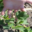

In [ ]:
img_list_cnn[500]

In [ ]:
img_list_cnn[0].shape, img_list_org256.shape

((32, 32, 3), (919, 256, 256, 3))

In [ ]:
print(mask2rle(img_mask_list[500]))

In [ ]:
resized_images = [resize(img, (32, 32)) for img in img_list_cnn]
# resized_images = [resize(img, (64, 64)) for img in img_list_cnn]

# Flatten the images into vectors
data = np.array([img.flatten() for img in resized_images])

# Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data)

# # Perform SVD
# U, S, Vt = np.linalg.svd(scaled_data, full_matrices=False)

# # Choose the top k singular values/vectors
# k = 100
# U_k = U[:, :k]
# S_k = np.diag(S[:k])
# Vt_k = Vt[:k, :]

# # Project the data onto the top k singular vectors
# reduced_data = np.dot(U_k, S_k)
pca = PCA(num_of_components=100)
pca.fit(data)



In [ ]:
data.shape # Number of samples x Flattened image dimension(here 32x32x3)

(919, 3072)

In [ ]:
pca.Vt_k.shape

(100, 3072)

In [ ]:
# pca2 = PCA(num_of_components=2)
# pca2.fit(data)

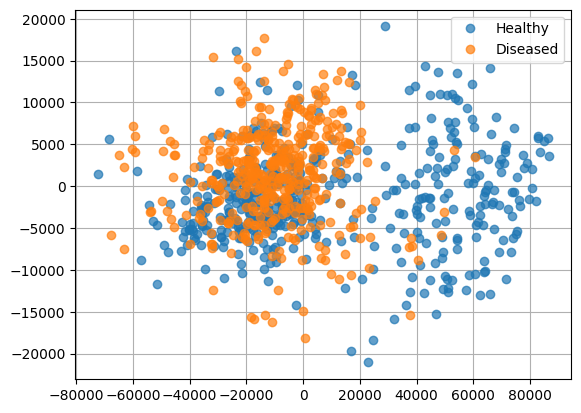

(919, 100)


In [ ]:
X_pca2comp = pca.transform(data)
X1= X_pca2comp[y_train==0]
X2= X_pca2comp[y_train==1]
# plt.plot(X_pca2comp[:, 0], X_pca2comp[:, 1], 'o', label='rd stuff 2')
plt.plot(X1[:, 0], X1[:, 1], 'o', label='Healthy', alpha=0.7)
plt.plot(X2[:, 0], X2[:, 1], 'o', label='Diseased', alpha=0.7)
plt.grid()
plt.legend()
plt.show()
print(X_pca2comp.shape)

In [ ]:
X_pca2comp.shape

(919, 100)

# Classification

In [ ]:
# X_temp1 = pca.get_reduced_data()
# plt.plot(X_temp1[0], X_temp1[1], 'o', label="random stuff")
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_images_np, val_images_np, train_labels_np, val_labels_np = train_test_split(img_list_cnn, y_train, test_size=0.2, random_state=42)
train_images_np, val_images_np, train_labels_np, val_labels_np = train_test_split(img_list_org256, y_train, test_size=0.2, random_state=42)
print(img_list_cnn.shape)
# Convert the numpy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images_np, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_np, dtype=torch.float32)
val_images_tensor = torch.tensor(val_images_np, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels_np, dtype=torch.float32)

# Create DataLoaders for training and validation data
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
batch_size = 25
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

(919, 32, 32, 3)


In [ ]:
# train_loader = train_loader.to(device)
# val_loader = val_loader.to(device)

In [ ]:
img_list_cnn.shape, y_train.shape

((919, 32, 32, 3), (919,))

In [ ]:
train_images_np.shape, val_images_np.shape, train_labels_np.shape, val_labels_np.shape

((735, 256, 256, 3), (184, 256, 256, 3), (735,), (184,))

In [ ]:

import torchvision.models as models
from torchvision.transforms.functional import InterpolationMode

vgg19 = models.vgg19_bn(pretrained=True)
# vgg19 = models.vgg19(pretrained=True)

# Freeze the VGG-19 model's parameters
for param in vgg19.parameters():
    param.requires_grad = False

vgg19.classifier = nn.Sequential(*[vgg19.classifier[i] for i in range(5)])


# Modify the model for segmentation
class VGG19Classification(nn.Module):
    def __init__(self):
        super(VGG19Classification, self).__init__()
        self.features = vgg19.features
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.Conv2d(256, 64, kernel_size=1),  # Output mask channel
            nn.ReLU(inplace=True),
        )
        # self.fc1 = nn.Linear(64, 16) # 32x32
        \
        # self.fc2 = nn.Linear(16, 1) # 32x32
        self.fc1 = nn.Linear(64*2*2, 16*2) # 256x256
        self.fc2 = nn.Linear(16*2, 1) # 256x256

    def forward(self, x):
        x = self.features(x)
        x = F.max_pool2d(x, 2)
        x = self.decoder(x)
        x = F.max_pool2d(x, 2)
        # print(x.shape)
        x = x.reshape(-1, 64*2*2)
        # x = x.reshape(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# import torch
# import torch.nn as nn

# num_of_epochs = 14  # Golden number of epochs

num_of_epochs = 50



class MyCnnModel(nn.Module):
  def __init__(self):
    super(MyCnnModel, self).__init__()
    # self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    # self.conv4 = nn.Conv2d(64, 64, kernel_size=1, padding=0)
    # self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc1 = nn.Linear(64 * 4 * 4, 128)
    # self.fc1 = nn.Linear(64 * 2 * 2, 128)
    # self.fc1 = nn.Linear(64 * 4 * 4, 256)
    # self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2)
    # x = F.relu(self.conv4(x))
    # x = F.max_pool2d(x, 2)
    # print(x.shape)
    # x = x.view(-1, 64 * 8 * 8)
    # x = x.view(-1, 64 * 4 * 4)


    # x = x.reshape(-1, 64 * 2 * 2)
    x = x.reshape(-1, 64 * 4 * 4)
    # x = x.reshape(-1, 64 * 8 * 8)
    x = F.relu(self.fc1(x))
    # x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return torch.sigmoid(x)

# cnn_model = MyCnnModel()
cnn_model = VGG19Classification()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)


curr_epoch = []
curr_epoch_batch = []
epoch_loss = []
f1_scores = []
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.BCELoss()

cnn_model.train()
cnn_model.to(device)
# Train the cnn_model
for epoch in range(num_of_epochs):
  # cnn_model.train()
  # cnn_model.train()
  true_positive = 0
  groundtruth_positive = 0
  predicted_positive = 0
  # false_positive = 0
  # false_negative = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.permute(0, 3, 1, 2)
    images = images.to(device)
    labels = labels.to(device)
    # print(images.shape, labels.shape) # The input for nn.Conv2d should be N, C, H, W, images is of dimension N, H, W, C
    optimizer.zero_grad()


    outputs = cnn_model(images)
    outputs = outputs.squeeze()
    labels = labels.squeeze()
    # print(outputs.shape, labels.shape)
    loss = loss_fn(outputs, labels)
    # binary_predictions = (outputs>=0.5).astype(np.int)
    # true_positive += np.sum((labels == 1) & (binary_predictions == 1))
    # groundtruth_positive += np.sum(labels == 1)
    # predicted_positive += np.sum(binary_predictions == 1)

    binary_predictions = (outputs >= 0.5).int()
    true_positive = torch.sum((labels == 1) & (binary_predictions == 1)).item()
    groundtruth_positive = torch.sum(labels == 1).item()
    predicted_positive = torch.sum(binary_predictions == 1).item()

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {loss.item():.5f}')
      curr_epoch_batch.append(epoch+1)
      epoch_loss.append(loss.item())
    curr_epoch.append(epoch+1)
    f1_scores.append(f1_score(true_positive, groundtruth_positive, predicted_positive))

# Evaluate the cnn_model
cnn_model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  # for images, labels in test_loader:
  for images, labels in val_loader:
    images = images.permute(0, 3, 1, 2)
    labels = labels.squeeze()
    images = images.to(device)
    labels = labels.to(device)

    outputs = cnn_model(images)
    outputs = outputs.squeeze()
    predictions = (outputs >= 0.5).float()
    # print(predictions.int())
    correct += torch.sum(predictions == labels)
    total += labels.size(0)

  accuracy = correct / total
  print(f'Accuracy: {accuracy.item():.5f}')



Epoch: 1, Batch: 1, Loss: 0.69861
Epoch: 2, Batch: 1, Loss: 0.21874
Epoch: 3, Batch: 1, Loss: 0.19222
Epoch: 4, Batch: 1, Loss: 0.05943
Epoch: 5, Batch: 1, Loss: 0.05191
Epoch: 6, Batch: 1, Loss: 0.00471
Epoch: 7, Batch: 1, Loss: 0.00224
Epoch: 8, Batch: 1, Loss: 0.00225
Epoch: 9, Batch: 1, Loss: 0.00108
Epoch: 10, Batch: 1, Loss: 0.00442
Epoch: 11, Batch: 1, Loss: 0.09138
Epoch: 12, Batch: 1, Loss: 0.00338
Epoch: 13, Batch: 1, Loss: 0.01009
Epoch: 14, Batch: 1, Loss: 0.00212
Epoch: 15, Batch: 1, Loss: 0.03193
Epoch: 16, Batch: 1, Loss: 0.00168
Epoch: 17, Batch: 1, Loss: 0.00077
Epoch: 18, Batch: 1, Loss: 0.00390
Epoch: 19, Batch: 1, Loss: 0.00033
Epoch: 20, Batch: 1, Loss: 0.00096
Epoch: 21, Batch: 1, Loss: 0.01425
Epoch: 22, Batch: 1, Loss: 0.00048
Epoch: 23, Batch: 1, Loss: 0.00550
Epoch: 24, Batch: 1, Loss: 0.00581
Epoch: 25, Batch: 1, Loss: 0.00161
Epoch: 26, Batch: 1, Loss: 0.00014
Epoch: 27, Batch: 1, Loss: 0.00007
Epoch: 28, Batch: 1, Loss: 0.00020
Epoch: 29, Batch: 1, Loss: 0.

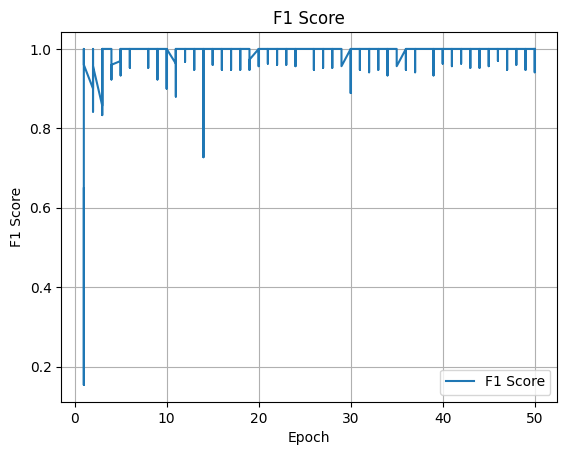

In [ ]:
plt.plot(curr_epoch, f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# img = rle2mask(' ')
# img
# k = mask2rle(img)
# k

In [ ]:
# torch.save(cnn_model.state_dict(), working_dir+'/cnn_model_temp.pth')
torch.save(cnn_model.state_dict(), working_dir+'/cnn_model_temp.pth')

In [ ]:
# cnn_model_loaded = MyCnnModel()
cnn_model_loaded = VGG19Classification()
# cnn_model_loaded.load_state_dict(torch.load(working_dir+'/cnn_model_temp.pth'))
cnn_model_loaded.load_state_dict(torch.load(working_dir+'/cnn_model_temp.pth'))
cnn_model_loaded.to(device)
cnn_model_loaded.eval()

VGG19Classification(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14):

In [ ]:

with torch.no_grad():
  correct = 0
  total = 0
  # for images, labels in test_loader:
  for images, labels in val_loader:
    images = images.permute(0, 3, 1, 2)
    labels = labels.squeeze()
    images = images.to(device)
    labels = labels.to(device)

    outputs = cnn_model_loaded(images)
    outputs = outputs.squeeze()
    predictions = (outputs >= 0.5).float()
    # print(images.shape, predictions.shape)
    # print(predictions)
    correct += torch.sum(predictions == labels)
    total += labels.size(0)

  accuracy = correct / total
  print(f'Accuracy: {accuracy.item():.4f}')


Accuracy: 0.9620


In [ ]:
# from pathlib import Path

# model_path = Path("./models")
# model_path.mkdir(parents=True,exist_ok=True)

# model_name = "model_0.pth"
# model_save_path =  model_path / model_name

# print(model_save_path)

# torch.save(model_0.state_dict(),model_save_path)

In [ ]:
# import torchvision.models as models
# from torchvision.transforms.functional import InterpolationMode

# # vgg19 = models.vgg19_bn(pretrained=True)
# vgg19v2 = models.vgg19(pretrained=True)

# # Freeze the VGG-19 model's parameters
# for param in vgg19v2.parameters():
#     param.requires_grad = False

# vgg19v2.classifier = nn.Sequential(*[vgg19v2.classifier[i] for i in range(5)])

# # Modify the model for segmentation
# class VGG19SegmentationV2(nn.Module):
#     def __init__(self):
#         super(VGG19SegmentationV2, self).__init__()
#         self.features = vgg19.features
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4096, out_features=4096, bias=True),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(8, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#             nn.Conv2d(256, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 1, kernel_size=1)  # Output mask channel
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.decoder(x)
#         return x


# Add your own layers
# Assuming the input image size is 256x256
# model.classifier[6] = nn.Linear(in_features=4096, out_features=4096, bias=True)
# model.classifier.add_module("7", nn.ReLU(inplace=True))
# model.classifier.add_module("8", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
# model.classifier.add_module("9", nn.ReLU(inplace=True))
# model.classifier.add_module("9.5", nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))  # MaxPool
# model.classifier.add_module("10", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
# model.classifier.add_module("11", nn.ReLU(inplace=True))
# model.classifier.add_module("12", nn.Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
# model.classifier.add_module("13", nn.ReLU(inplace=True))
# model.classifier.add_module("14", nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True))  # Upsample to 256x256

Self Made U-Net model

In [ ]:
# import torch
# import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv_last(dec1))
        # return self.conv_last(dec1)

# Instantiate the model
# model = UNet(in_channels=3, out_channels=1).to('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class SmallUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SmallUNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 32)  # Reduced filters
        self.encoder2 = conv_block(32, 64)           # Reduced filters
        self.encoder3 = conv_block(64, 128)          # Reduced filters
        self.encoder4 = conv_block(128, 256)         # Reduced filters

        self.bottleneck = conv_block(256, 512)       # Reduced filters

        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = conv_block(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = conv_block(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 32)

        self.conv_last = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv_last(dec1))
        # return self.conv_last(dec1)

# Instantiate the model
model = SmallUNet(in_channels=3, out_channels=1).to('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# class SegmentationNet(nn.Module):
#     def __init__(self):
#         super(SegmentationNet, self).__init__()
#         # self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
#         # self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
#         # # self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         # # self.conv4 = nn.Conv2d(128, 64, 3, padding=1)
#         # self.conv5 = nn.Conv2d(64, 1, 1)

#         # self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         # # self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         # # self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
#         # self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
#         # self.conv5 = nn.Conv2d(8, 1, 1)
#         self.conv1 = nn.Conv2d(3, 4, 3, padding=1)
#         # self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         # self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
#         self.conv2 = nn.Conv2d(4, 4, 3, padding=1)
#         self.conv3 = nn.Conv2d(4, 8, 3, padding=1)
#         self.conv4 = nn.Conv2d(8, 4, 3, padding=1)
#         self.conv5 = nn.Conv2d(4, 4, 3, padding=1)
#         self.conv6 = nn.Conv2d(4, 1, 1)

#     def forward(self, x):
#         # x = torch.relu(self.conv1(x))
#         # x = torch.relu(self.conv2(x))
#         # # x = torch.relu(self.conv3(x))
#         # # x = torch.relu(self.conv4(x))
#         # # x = torch.sigmoid(self.conv5(x))
#         # x = torch.sigmoid(self.conv5(x))


#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = torch.relu(self.conv3(x))
#         x = torch.relu(self.conv4(x))
#         x = torch.relu(self.conv5(x))
#         # x = torch.sigmoid(self.conv5(x))
#         x = torch.sigmoid(self.conv6(x))
#         return x

# Segmentation

In [ ]:
import torchvision.models as models
from torchvision.transforms.functional import InterpolationMode

# vgg19 = models.vgg19_bn(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

# Freeze the VGG-19 model's parameters
for param in vgg19.parameters():
    param.requires_grad = False

# Modify the model for segmentation
class VGG19Segmentation(nn.Module):
    def __init__(self):
        super(VGG19Segmentation, self).__init__()
        self.features = vgg19.features
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1, kernel_size=1)  # Output mask channel
        )

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 167MB/s]


In [ ]:
# import torchvision.models as models
# from torchvision.transforms.functional import InterpolationMode

# vgg19v2 = models.vgg19_bn(pretrained=True)
vgg19v2 = models.vgg19(pretrained=True)

# Freeze the VGG-19 model's parameters
for param in vgg19v2.parameters():
    param.requires_grad = False

vgg19v2.classifier = nn.Sequential(*[vgg19v2.classifier[i] for i in range(5)])

# Modify the model for segmentation
class VGG19SegmentationV2(nn.Module):
    def __init__(self):
        super(VGG19SegmentationV2, self).__init__()
        self.features = vgg19.features
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            # nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            # nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
            # nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 1, kernel_size=1)  # Output mask channel
        )
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        # x = self.sigmoid(x)
        return x

comment = "Good Working Model Uncomment and use"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:12<00:00, 45.9MB/s]


In [ ]:
# # import torchvision.models as models
# # from torchvision.transforms.functional import InterpolationMode

# # vgg19v2 = models.vgg19_bn(pretrained=True)
# vgg19v2 = models.vgg19(pretrained=True)

# # Freeze the VGG-19 model's parameters
# for param in vgg19v2.parameters():
#     param.requires_grad = False

# vgg19v2.classifier = nn.Sequential(*[vgg19v2.classifier[i] for i in range(5)])

# # Modify the model for segmentation
# class VGG19SegmentationV2(nn.Module):
#     def __init__(self):
#         super(VGG19SegmentationV2, self).__init__()
#         self.features = vgg19.features
#         self.decoder = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),

#             # nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
#             # nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#             nn.Conv2d(64, 1, kernel_size=1)  # Output mask channel
#         )
#         # self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.features(x)
#         x = self.decoder(x)
#         # x = self.sigmoid(x)
#         return x



In [ ]:
# print(vgg19v2)

In [ ]:
# import torchvision.models as models
# from torchvision.transforms.functional import InterpolationMode

# vgg19 = models.vgg19_bn(pretrained=True)

# # Freeze the VGG-19 model's parameters
# for param in vgg19.parameters():
#     param.requires_grad = False

# # Modify the model for segmentation
# class VGG19Segmentation256(nn.Module):
#     def __init__(self):
#         super(VGG19Segmentation256, self).__init__()
#         self.features = vgg19.features
#         self.avgpool = vgg19.avgpool
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, 256 * 256)  # Output 256x256 image (1 channel)
#         )


#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         x = x.view(-1, 1, 256, 256)
#         return x

In [ ]:
# train_images_np, val_images_np, train_labels_np, val_labels_np = train_test_split(img_list_org256, img_mask_list, test_size=0.2, random_state=42)
# train_images_tensor = torch.tensor(train_images_np, dtype=torch.float32)
# train_masks_tensor = torch.tensor(train_labels_np, dtype=torch.float32)

# train_images_tensor = torch.tensor(img_list_org256, dtype=torch.float32)
# train_masks_tensor = torch.tensor(img_mask_list, dtype=torch.float32)
# train_y_tensor = torch.tensor(y_train, dtype=torch.float32)

train_images_tensor = torch.tensor(img_list_org256[y_train==1], dtype=torch.float32)
train_masks_tensor = torch.tensor(img_mask_list[y_train==1], dtype=torch.float32)
train_y_tensor = torch.tensor(y_train[y_train==1], dtype=torch.float32)

train_dataset = TensorDataset(train_images_tensor, train_masks_tensor, train_y_tensor)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader2 = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)

In [ ]:
# import torch.optim as optim


# seg_net = UNet(in_channels=3, out_channels=1)
# # Define the loss function and optimizer
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# # Training loop
# num_epochs = 25
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0

#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)

#         # Use a differentiable approach to handle the outputs instead of torch.where
#         outputs = torch.sigmoid(outputs)  # Ensure outputs are in the range (0, 1)
#         outputs = outputs * (msk_max - msk_min) + msk_min  # Scale outputs to the range (msk_min, msk_max)

#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     val_loss = 0
#     model.eval()
#     with torch.no_grad():
#         for images, masks in val_loader:
#             images, masks = images.to(device), masks.to(device)
#             outputs = model(images)
#             outputs = torch.sigmoid(outputs)  # Ensure outputs are in the range (0, 1)
#             outputs = outputs * (msk_max - msk_min) + msk_min  # Scale outputs to the range (msk_min, msk_max)
#             loss = criterion(outputs, masks)
#             val_loss += loss.item()

#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')


In [ ]:
# seg_net = SegmentationNet()
# seg_net = VGG19Segmentation256()
# criterion = nn.BCELoss()
# optimizer = optim.Adam(seg_net.parameters(), lr=0.001)
# input_size = (1024, 1024) # increase resulution uncomment
# output_size = (32, 32)
# input_size = (512, 512) # increase resulution uncomment
# output_size = (16, 16)

# input_size = (256, 256) # Default Uncomment
# output_size = (256, 256)  # Default Uncomment
# org_output_size = (8, 8)

num_epochs = 120
# seg_net = VGG19Segmentation()
# seg_net = VGG19SegmentationV2()
seg_net = UNet(in_channels=3, out_channels=1)
# seg_net = SmallUNet(in_channels=3, out_channels=1)
seg_net.to(device)
# print(seg_net)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
# optimizer = optim.Adam(seg_net.parameters(), lr=0.00005)
optimizer = optim.Adam(seg_net.parameters(), lr=0.0001)
seg_net.to(device)

threshold_sigmoid = 0.5

# Train the network
for epoch in range(num_epochs):
  seg_net.train()
  for images, masks, y_vals in train_loader:
    images = images.permute(0, 3, 1, 2)
    # masks = masks.unsqueeze(1)
    # print(masks.shape)
    # masks = torch.nn.functional.interpolate(masks, size=org_output_size, mode='bilinear', align_corners=False)
    masks = masks.squeeze() # Default uncomment
    # masks = torch.where(masks>127.5, 1.0, 0.0)
    # print(masks.shape)
    # images = torch.nn.functional.interpolate(images, size=input_size, mode='bilinear', align_corners=False) # comment default
    images, masks = images.to(device), masks.to(device)
    msk_min = float(torch.min(masks))
    msk_max = float(torch.max(masks))
    # print(masks.shape, images.shape)
    optimizer.zero_grad()
    outputs = seg_net(images)
    # print(outputs.shape)
    # print("*****************************************************************")
    # print(msk_min, msk_max)
    # print(torch.min(outputs), torch.max(outputs))
    # print("*****************************************************************")
    # mask_mean = int((msk_min + msk_max) / 2)
    # print(mask_mean)
    # outputs = torch.nn.functional.interpolate(outputs, size=output_size, mode='bilinear', align_corners=False
    # print(mask_mean, type(mask_mean))
    # masks = masks.unsqueeze(dim = (1))
    # masks = torch.nn.functional.interpolate(masks, size=output_size, mode='bilinear', align_corners=False) # comment default
    # masks = masks.squeeze()  # comment default
    # outputs = torch.nn.functional.interpolate(outputs, size=output_size, mode='bilinear', align_corners=False)
    outputs = outputs.squeeze()
    # outputs = (outputs >= threshold_sigmoid).float()
    # outputs = outputs * (msk_max - msk_min) + msk_min
    # outputs = torch.where(outputs < mask_mean, msk_min*1.0, msk_max*1.0)
    # outputs = torch.where(outputs < mask_mean, torch.tensor(msk_min*1.0), torch.tensor(msk_max*1.0))
    # outputs = outputs.to(torch.float32)
    # outputs = torch.where(outputs < mask_mean, 0, 255)
    # print(outputs.shape)
    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}, Loss: {loss.item()}")
seg_net.eval()

Epoch 1, Loss: 0.3034602999687195
Epoch 2, Loss: 0.45286399126052856
Epoch 3, Loss: 0.9839850664138794
Epoch 4, Loss: 0.4886721968650818
Epoch 5, Loss: 0.5155563950538635
Epoch 6, Loss: 0.19759607315063477
Epoch 7, Loss: 0.320081889629364
Epoch 8, Loss: 0.2834019660949707
Epoch 9, Loss: 0.6120848059654236
Epoch 10, Loss: 0.18499577045440674
Epoch 11, Loss: 0.21308691799640656
Epoch 12, Loss: 0.2213808000087738
Epoch 13, Loss: 0.34633660316467285
Epoch 14, Loss: 0.24660930037498474
Epoch 15, Loss: 0.2935887575149536
Epoch 16, Loss: 0.6092948317527771
Epoch 17, Loss: 0.5485318899154663
Epoch 18, Loss: 0.25335693359375
Epoch 19, Loss: 0.45282644033432007
Epoch 20, Loss: 0.2902238368988037
Epoch 21, Loss: 0.2272750586271286
Epoch 22, Loss: 0.34767740964889526
Epoch 23, Loss: 0.23677445948123932
Epoch 24, Loss: 0.18550316989421844
Epoch 25, Loss: 0.25201356410980225
Epoch 26, Loss: 0.21999317407608032
Epoch 27, Loss: 0.19162064790725708
Epoch 28, Loss: 0.15792208909988403
Epoch 29, Loss: 0.

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Con

In [ ]:
# torch.save(cnn_model.state_dict(), working_dir+'/cnn_model_1.pth')
torch.save(seg_net.state_dict(), working_dir+'/seg_net_Unet_large_batchSize1.pth')

torch.Size([8, 256, 256, 3]) torch.Size([8, 256, 256]) torch.Size([8])
8.6963935e-34 1.0
0 1


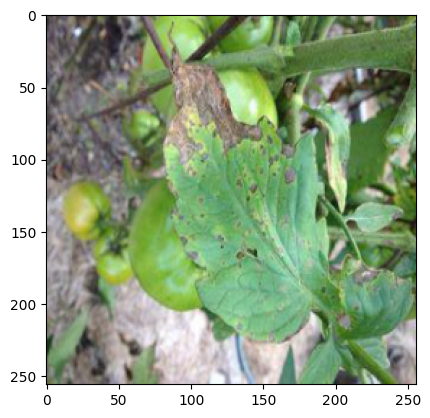

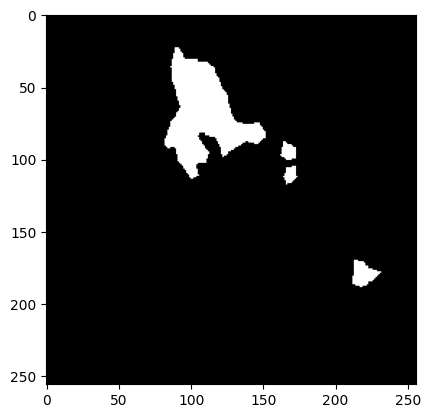

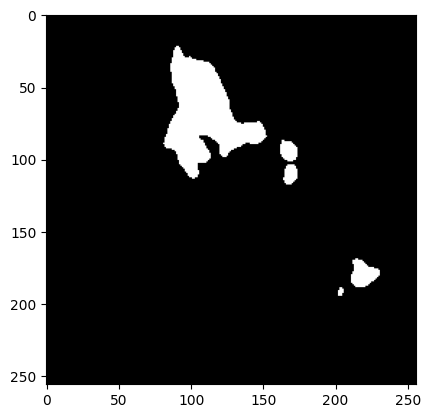

In [ ]:
# input_size = (256, 256)
# output_size = (256, 256)
for images, masks, y_vals in train_loader2:
  permuted_images = images.permute(0, 3, 1, 2)
  # permuted_images = torch.nn.functional.interpolate(permuted_images, size=input_size, mode='bilinear', align_corners=False)
  # permuted_images = torch.nn.functional.interpolate(permuted_images, size=input_size, mode='bilinear', align_corners=False)
  # permuted_images = np.kron(permuted_images, np.ones((32, 32), dtype=permuted_images.dtype))
  # permuted_images = np.kron(permuted_images, np.ones((32, 32), dtype=torch.uint8))
  print(images.shape, masks.shape, y_vals.shape)
  permuted_images = permuted_images.to(device)
  output = seg_net(permuted_images)
  # output = torch.nn.functional.interpolate(output, size=output_size, mode='bilinear', align_corners=False)
  output = output.squeeze()
  output = output.cpu()
  # print(output)
  # output = np.where(output<128, 0, 255)
  output = output.detach().numpy()
  # img = np.array(images[0], dtype=np.uint8)
  test_idx=0
  for y in range(len(y_vals)):
    if y_vals[y] == 1:
      test_idx = int(y)
  img = images[test_idx].numpy().astype(np.uint8)
  # img = images[test_idx]
  # msk = masks[test_idx].numpy().astype(np.uint8)
  msk = masks[test_idx].numpy().astype(np.uint8)
  # otp = output[test_idx].detach().numpy().astype(np.uint8)
  # otp = output[test_idx].astype(np.uint8)
  otp = output[test_idx]
  msk_min = np.min(otp)
  msk_max = np.max(otp)
  print(msk_min, msk_max)
  # otp = (otp - msk_min) * (255 / (msk_max - msk_min))
  otp = np.where(otp<0.05, 0, 255)
  # otp = np.where(otp<128, 0, 255)
  # otp = np.where(otp<127.5, 0, 255)
  # otp = otp.astype(np.uint8)
  # otp = np.kron(otp, np.ones((32, 32), dtype=otp.dtype))
  msk_min = np.min(msk)
  msk_max = np.max(msk)
  print(msk_min, msk_max)




  # print(images[0].shape, masks[0].shape, output[0].shape)
  plt.imshow(img)
  plt.show()
  # plt.imshow(masks[0], cmap='gray')
  plt.imshow(msk, cmap='gray')
  plt.show()
  plt.imshow(otp, cmap='gray')
  # plt.imshow(output[0], cmap='gray')
  break

In [ ]:

# # test_img = np.array(img_list_org256[:1])
# test_img = np.array(img_list_org256[0])
# # test_mask = np.array(img_mask_list[:1])
# test_mask = np.array(img_mask_list[0])
# plt.imshow(test_img)
# plt.show()
# plt.imshow(test_mask, cmap='gray')
# plt.show()
# predicted_mask = seg_net.

# Write the output file

In [ ]:
def test_image_preprocessing(src_image):
  return src_image[:, :, :3]

In [ ]:
output_size = (256, 256)
def resizeMask2_256(src_mask):
  output = src_mask
  # output = torch.nn.functional.interpolate(output, size=output_size, mode='bilinear', align_corners=False)
  output = output.squeeze()
  # output = src_mask.squeeze()
  # output = src_mask.squeeze()
  output = output.cpu()
  # print(output)
  # output = np.where(output<128, 0, 255)
  output = output.detach().numpy()
  # otp = output[0]
  otp = output
  # msk_min = 0
  # msk_max = 255
  # otp = (otp - msk_min) * (255 / (msk_max - msk_min))
  # otp = np.where(otp<128, 0, 0)
  # otp = np.where(otp<128, 0, 255)

  otp = np.where(otp<0.2, 0, 255)
  # otp = np.where(otp<128, 0, 255)
  otp = otp.astype(np.uint8)
  otp = torch.tensor(otp) # Do not perform image interpolation after masking
  otp = otp.squeeze()
  return otp


  # print(otp.shape)
  # otp = otp.unsqueeze(0).unsqueeze(1)
  # otp = np.kron(otp, np.ones((32, 32), dtype=otp.dtype))
  # otp = torch.nn.functional.interpolate(otp, size=output_size, mode='bilinear', align_corners=False)

In [ ]:
# cnn_model_loaded = cnn_model
# cnn_model_loaded = MyCnnModel()
# cnn_model_loaded.load_state_dict(torch.load(working_dir+'/cnn_model_8424.pth'))
cnn_model_loaded.eval()

VGG19Classification(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14):

In [ ]:
seg_model_loaded = seg_net
seg_model_loaded.eval()
# seg_model_loaded = VGG19Segmentation()
# seg_model_loaded.load_state_dict(torch.load(working_dir+'/seg_net_temp.pth'))

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Con

In [ ]:
img_folder_path = working_dir+f'/test/test'
# List to store the images

df = pd.read_csv(working_dir+'/test.csv')
df.set_index('id', inplace=True)

input_size = (256, 256)
image_height, image_width = 32, 32
cnn_model_loaded = cnn_model_loaded.to(device)
seg_model_loaded = seg_model_loaded.to(device)
# Iterate over the files in the folder
for filename in os.listdir(img_folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Filter for image files
        # Read the image and append it to the img_list_cnn
        img_path = os.path.join(img_folder_path, filename)
        img = io.imread(img_path)
        img1 = test_image_preprocessing(img)
        # img1_cnn = image_resizing(img1, image_height, image_width, img1.shape[2])
        img1_cnn = img1
        img_tensor_cnn = torch.tensor([img1_cnn], dtype=torch.float32)
        img_tensor_cnn = img_tensor_cnn.permute(0, 3, 1, 2)
        img_tensor_cnn = img_tensor_cnn.to(device)
        y_pred = cnn_model(img_tensor_cnn)
        # print(y_pred)
        y_pred = y_pred.squeeze()
        # y_pred = (y_pred >= 0.5).int()
        # print(y_pred)
        y_pred = y_pred.cpu()
        y_pred = np.where(y_pred<=0.5, 0, 1)
        # print(y_pred)
        # print(img_tensor_cnn.shape, y_pred.numpy())

        df.loc[filename, 'binary_pred'] = int(y_pred) # UNCOMMENT these 4 lines
        if y_pred == 0:
          df.loc[filename, 'segmentation_pred'] = "Healthy"
          continue

        # print(filename, y_pred)

        # print(img1.shape)



        img_tensor = torch.tensor([img1], dtype=torch.float32)
        img_tensor = img_tensor.permute(0, 3, 1, 2)
        img_tensor = img_tensor.to(device)
        # print(img_tensor.shape)
        # img_tensor = torch.nn.functional.interpolate(img_tensor, size=input_size, mode='bilinear', align_corners=False)
        mask_pred = seg_model_loaded(img_tensor)
        # print(mask_pred.shape)
        mask_pred = mask_pred.squeeze()

        mask_pred = resizeMask2_256(mask_pred)
        # plt.imshow(mask_pred.numpy(), cmap='gray')
        # plt.show()
        # print(mask_pred.shape)
        # mask_pred = torch.tensor(mask_pred)

        stacked_mask = torch.stack([mask_pred, mask_pred, mask_pred], dim=2)
        # print(stacked_mask.shape)
        image_rle = mask2rle(stacked_mask.numpy())
        # print(image_rle)
        df.loc[filename, 'segmentation_pred'] = str(image_rle)
        if(str(image_rle) == ''):
          df.loc[filename, 'segmentation_pred'] = " "  # Uncomment
          # df.loc[filename, 'segmentation_pred'] = "Healthy" # Comment
          # df.loc[filename, 'binary_pred'] = 0 # Comment
        # img1 , mask1 = image_mask_splitter(img)
        # print(img[:,:,3])
        # img_list_org256.append(img1)
        # img1_resized = image_resizing(img1, image_height, image_width, img1.shape[2])
        # mask1_resized = image_resizing(mask1, image_height, image_width, 1)
        # img_list_cnn.append(img1_resized)
        # # img_mask_list.append(mask1_resized)
        # img_mask_list.append(mask1)
        # y_train_values.append(df.loc[filename, 'binary_pred'])

# Now, img_list_cnn contains all the images from the folder

# df = df[['id', 'binary_pred', 'segmentation_pred']]
df.to_csv(working_dir+'/output/test_output_raw.csv', float_format='%.0f', index=True)


In [ ]:
# df = df[['id', 'binary_pred', 'segmentation_pred']]
# df.to_csv(working_dir+'/output/test_output.csv', index=False)
# df.to_csv(working_dir+'/output/test_output.csv', index=True)
df.to_csv(working_dir+'/output/test_output.csv', float_format='%.0f', index=True)
# df.to_csv(working_dir+'/output/test2_output.csv', float_format={'binary_pred': '%.0f'}, index=True)

In [ ]:
df.describe(include = 'all')

,binary_pred,segmentation_pred
count,394.000000,394
unique,NaN,145
top,NaN,Healthy
freq,NaN,250
mean,0.365482,NaN
std,0.482177,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,1.000000,NaN


In [ ]:
cntr = 0
for idx, row in df.iterrows():
  print(row)
  if(cntr == 5):
    break
  cntr+=1

binary_pred                                                        0.0
segmentation_pred    1 16 18 1 20 1 22 1 24 1 26 1 28 1 30 1 32 1 3...
Name: Img_919.png, dtype: object
binary_pred                                                        1.0
segmentation_pred    1 12372 12381 8 12397 104 12509 8 12525 101 12...
Name: Img_920.png, dtype: object
binary_pred                                                        0.0
segmentation_pred    1 12308 12317 8 12333 8 12349 8 12365 72 12445...
Name: Img_921.png, dtype: object
binary_pred                                                        1.0
segmentation_pred    113 1 115 1 117 1 119 1 121 1 123 1 125 1 127 ...
Name: Img_922.png, dtype: object
binary_pred                                                        1.0
segmentation_pred    1 4096 4117 8 4133 8 4309 8 4325 8 4353 17 437...
Name: Img_923.png, dtype: object
binary_pred                                                        0.0
segmentation_pred    1 20532 20541 8 20557 104 20669 8

In [ ]:
img_folder_path = working_dir+f'/test/test'
# List to store the images

df = pd.read_csv(working_dir+'/test.csv')
df.set_index('id', inplace=True)

# Iterate over the files in the folder
for filename in os.listdir(img_folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Filter for image files
        # Read the image and append it to the img_list_cnn
        df.loc[filename, 'binary_pred'] = int(8)

        df.loc[filename, 'segmentation_pred'] = '1 234 234 234 235 234 5 345 34 5 3464356  355 35  35 345 34 5 35 34 5 345 34'

df.to_csv(working_dir+'/output/dummy_csv_write_test.csv', index=True)


In [ ]:

# import pandas as pd

# Read the CSV file into a DataFrame
# df = pd.read_csv(working_dir+'/test.csv')

# Edit the contents of the DataFrame
# df['Column Name'] = df['Column Name'].apply(lambda x: x + '_edited')

# Write the DataFrame back to the CSV file

# df.to_csv(working_dir+'/output/test_output.csv', index=False)

In [ ]:
import torch

# Assuming image_tensor is your input tensor of shape N, 256, 256, 3
image_tensor = torch.randn(4, 256, 256, 3)

# Repeat the image tensor along the height and width dimensions
repeated_tensor = image_tensor.repeat(1, 2, 2, 1)

# Concatenate the repeated tensors to create the final tensor
resized_tensor = torch.cat([repeated_tensor, repeated_tensor.flip(1), repeated_tensor.flip(2), repeated_tensor.flip(1, 2)], dim=3)
# resized_tensor = torch.cat([repeated_tensor, repeated_tensor.flip(1), repeated_tensor.flip(2), repeated_tensor.flip(1, 2)], dim=3)

# Display the shape of the resized tensor
print("Resized tensor shape:", resized_tensor.shape)


Resized tensor shape: torch.Size([4, 512, 512, 12])


torch.Size([4, 1024, 1024, 3])


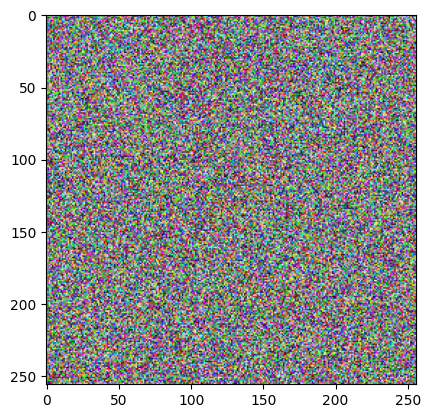

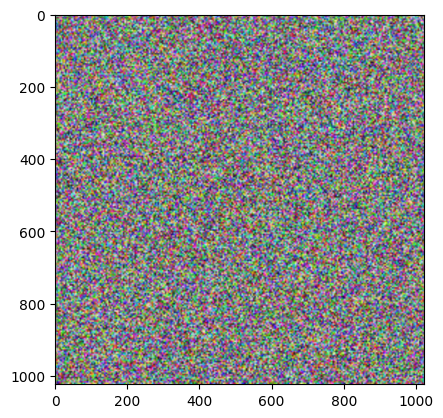

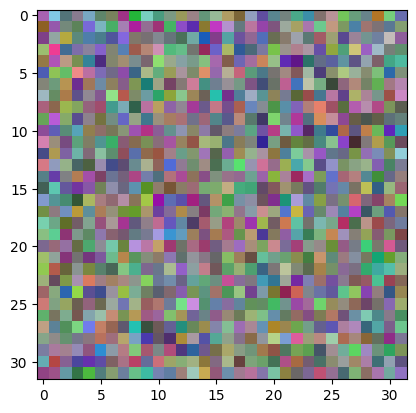

In [ ]:
N = 4
C = 3
H = 1024
W = 1024
# image_tensor = torch.randn(4, 3, 256, 256)
image_tensor = torch.randint(0, 256, size=(N, 3, 256, 256), dtype=torch.uint8)
new_img_tensor = torch.nn.functional.interpolate(image_tensor, size=(H, W), mode='bilinear', align_corners=False)
small_img_tensor = torch.nn.functional.interpolate(image_tensor, size=(32, 32), mode='bilinear', align_corners=False)

image_tensor = image_tensor.permute(0, 2, 3, 1)
new_img_tensor = new_img_tensor.permute(0, 2, 3, 1)
small_img_tensor = small_img_tensor.permute(0, 2, 3, 1)

print(new_img_tensor.shape)
plt.imshow(image_tensor[0])
plt.show()
plt.imshow(new_img_tensor[0])
plt.show()
plt.imshow(small_img_tensor[0])
plt.show()

In [ ]:
import torch
from torchvision import transforms

# Example image tensor with shape (N, C, H, W)
N = 4
img = torch.randint(0, 256, size=(N, 3, 256, 256), dtype=torch.uint8)

# Resize the images to 1024x1024
resize_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),  # Convert to tensor
])

# Apply the transformation
resized_img = resize_transform(img)

# If needed, stack multiple images into a batch
# batched_img = torch.stack([resized_img1, resized_img2, ...], dim=0)

# Optionally, convert to channels last memory format
# batched_img = batched_img.contiguous(memory_format=torch.channels_last)
print(resized_img.shape)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>